<a href="https://colab.research.google.com/github/aycakrk/DI725_Ayca/blob/main/assignment_2/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch torchvision wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
!rm -r /content/images

In [67]:
!rm /content/annotations_coco.json

In [ ]:
!unzip "/content/drive/MyDrive/auair2019.zip" -d "/content"


In [76]:
import json

with open('annotations.json', 'r') as f:
    original_data = json.load(f)

coco_data = {
    "info": original_data["info"],
    "licenses": original_data["licenses"],
    "images": [],
    "annotations": [],
    "categories": []
}

# Categories
for idx, cat_name in enumerate(original_data["categories"], 1):
    coco_data["categories"].append({
        "id": idx,
        "name": cat_name
    })

# Images & Annotations
ann_id = 1
for img_id, item in enumerate(original_data["annotations"], 1):
    coco_data["images"].append({
        "id": img_id,
        "file_name": item["image_name"],
        "width": int(item["image_width:"]),
        "height": int(item["image_height"])
    })

    for bbox_item in item["bbox"]:
        x, y, w, h = bbox_item["left"], bbox_item["top"], bbox_item["width"], bbox_item["height"]
        coco_data["annotations"].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": bbox_item["class"] + 1, # sınıf index'i 0'dan başlıyorsa
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        ann_id += 1

# Save COCO JSON
with open('annotations_coco.json', 'w') as f:
    json.dump(coco_data, f, indent=4)



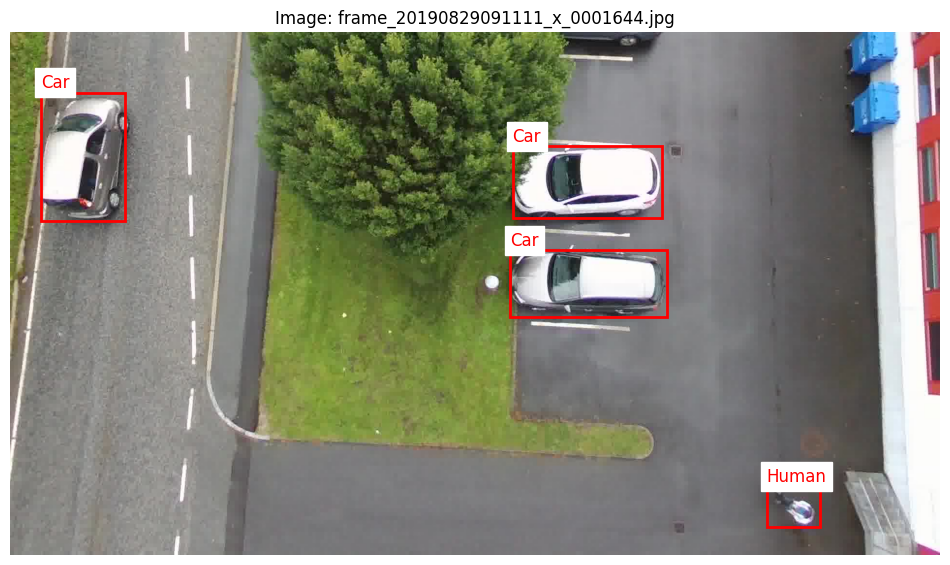

In [5]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

# COCO formatındaki json dosyasını oku
with open("/content/annotations_coco.json", "r") as f:
    coco = json.load(f)

# select an image
image_info = coco["images"][10]
image_id = image_info["id"]
image_path = os.path.join("/content/images", image_info["file_name"])

# Görseli yükle
image = Image.open(image_path)

# Plot başlat
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Annotations içinden bu görsele ait olanları filtrele
for ann in coco["annotations"]:
    if ann["image_id"] == image_id:
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        category_name = next(c["name"] for c in coco["categories"] if c["id"] == category_id)

        # draw Rectangle
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Kategori ismini yaz
        ax.text(bbox[0], bbox[1] - 10, category_name,
                color='red', fontsize=12, backgroundcolor='white')

plt.axis('off')
plt.title(f"Image: {image_info['file_name']}")
plt.show()


In [6]:
import os

image_folder = "/content/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]
print(f"Total image number: {len(image_files)}")



Total image number: 32823


## part 2

YOLOS

In [7]:
from transformers import AutoImageProcessor, YolosForObjectDetection
import torch

# Model ve işlemciyi yükle
processor = AutoImageProcessor.from_pretrained("hustvl/yolos-small")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

For one image (to see if working)

In [10]:
from PIL import Image
import requests
import torchvision.transforms as T

# Görseli yükle
image_path = "/content/images/frame_20190829091111_x_0001644.jpg"
image = Image.open(image_path)

# Preprocessing + model
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Sonuçları işlemeye hazırla
target_sizes = torch.tensor([image.size[::-1]])  # (H, W)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.7)[0]

# Tahminleri yazdır
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"{model.config.id2label[label.item()]}: {round(score.item(), 3)} - {box.tolist()}")


car: 0.986 - [54.8264274597168, 136.25433349609375, 252.22647094726562, 388.3740539550781]
car: 0.871 - [1127.5880126953125, 0.24330183863639832, 1360.2515869140625, 35.991336822509766]
car: 0.942 - [1027.4923095703125, 448.07135009765625, 1349.6182861328125, 583.2709350585938]
car: 0.975 - [1042.060546875, 229.04727172851562, 1343.460205078125, 386.9774475097656]


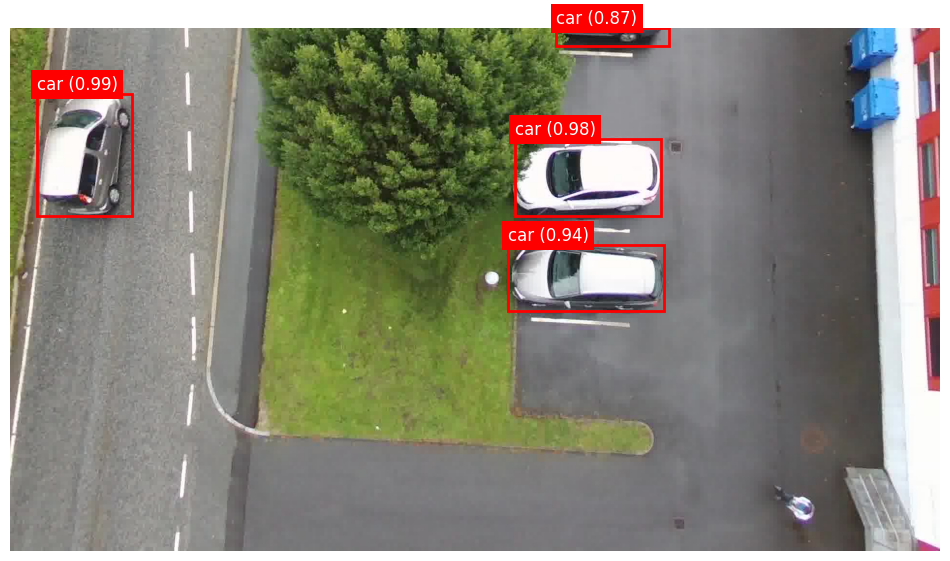

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Görseli yükle
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Bounding box çiz
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if score < 0.7:
        continue  # sadece güvenilir tahminleri çiz

    box = box.tolist()
    label_text = model.config.id2label[label.item()]

    # Kutu
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Etiket
    ax.text(box[0], box[1] - 10, f"{label_text} ({round(score.item(), 2)})",
            color='white', fontsize=12, bbox=dict(facecolor='red', edgecolor='none'))

plt.axis('off')
plt.show()


For 2000 images

In [15]:
import os
import random

# Tüm görsellerin bulunduğu klasör
image_dir = "/content/images"

# .jpg uzantılı dosyaları al
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Aynı seçim için sabit seed
random.seed(42)

# 2000 adet rastgele seçim
selected_images = random.sample(all_images, 2000)

# Seçilenleri kaydet
with open("/content/selected_images.txt", "w") as f:
    for name in selected_images:
        f.write(name + "\n")

print("2000 görsel seçildi ve kaydedildi.")


2000 görsel seçildi ve kaydedildi.


In [81]:
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
from transformers import DetrImageProcessor, YolosForObjectDetection
import wandb

# ✅ 1. WandB başlat
wandb.init(project="object_detection", name="yolos-inference-on-auair")

# ✅ 2. AU-AIR sınıf isimleri ve COCO → AU-AIR sınıf eşleme
coco_to_auair = {
    "person": 1, "car": 2, "truck": 3, "van": 4,
    "motorcycle": 5, "bicycle": 6, "bus": 7, "trailer": 8
}

# ✅ 3. Görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# ✅ 4. Model ve işlemciyi yükle
processor = DetrImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
model.eval().to("cuda")

# ✅ 5. Görsel klasörü ve JSON çıktısı
image_folder = "/content/images"
output_json = "/content/yolos_predictions_coco.json"
coco_predictions = []

# Ground truth annotations (image_name -> image_id eşlemesi)
with open('/content/annotations_coco.json', 'r') as f:
    gt_coco = json.load(f)
image_name_to_id = {img["file_name"]: img["id"] for img in gt_coco["images"]}

# ✅ 6. WandB tablosu oluştur
wandb_table = wandb.Table(columns=["Image", "Label", "Score", "BBox"])

# ✅ 7. Görselleri sırayla işle
for filename in tqdm(os.listdir(image_folder)):
    if not filename.endswith(".jpg") or filename not in selected_images:
        continue

    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        inputs_clean = {k: v for k, v in inputs.items() if k != "pixel_mask"}
        outputs = model(**inputs_clean)

    target_sizes = torch.tensor([image.size[::-1]]).to("cuda")
    results_per_image = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.7)[0]

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results_per_image["scores"],
                                 results_per_image["labels"],
                                 results_per_image["boxes"]):
        coco_label = model.config.id2label[label.item()]
        if coco_label not in coco_to_auair:
            continue

        category_id = coco_to_auair[coco_label]
        score_val = round(score.item(), 3)
        xmin, ymin, xmax, ymax = [round(b, 2) for b in box.tolist()]
        width, height = xmax - xmin, ymax - ymin

        # COCO formatına uygun kayıt
        coco_predictions.append({
            "image_id": image_name_to_id[filename],
            "category_id": category_id,
            "bbox": [xmin, ymin, width, height],
            "score": score_val
        })

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin - 10), f"{coco_label} ({score_val})", fill="red")

        wandb_table.add_data(filename, coco_label, score_val, [xmin, ymin, xmax, ymax])

    wandb.log({f"prediction/{filename}": wandb.Image(image)})

# ✅ 8. JSON çıktısını kaydet (COCO format)
with open(output_json, "w") as f:
    json.dump(coco_predictions, f, indent=2)

print(f"COCO formatında tahminler kaydedildi: {output_json}")

# ✅ 9. WandB tabloyu gönder ve oturumu kapat
wandb.log({"detection_table": wandb_table})
wandb.finish()


100%|██████████| 32823/32823 [11:33<00:00, 47.30it/s]


COCO formatında tahminler kaydedildi: /content/yolos_predictions_coco.json


Sınıf Bazlı Tespit Sayıları:
Car: 25036 (avg score: 0.831)
Truck: 1743 (avg score: 0.83)
Bus: 137 (avg score: 0.889)
Human: 190 (avg score: 0.846)
Motorbike: 11 (avg score: 0.794)
Bicycle: 6 (avg score: 0.788)


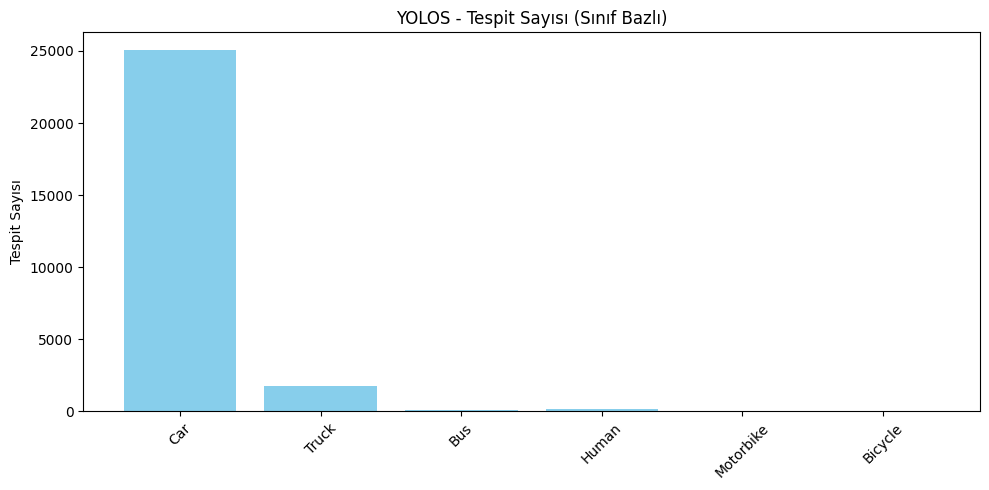

In [82]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Yeni COCO uyumlu YOLOS tahmin dosyasını yükle
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

# AU-AIR kategorileri (ID'den isimlere)
id_to_label = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# Sınıf bazlı istatistikleri topla
class_counts = defaultdict(int)
class_scores = defaultdict(list)

for det in yolos_preds:
    label = id_to_label[det["category_id"]]
    score = det["score"]
    class_counts[label] += 1
    class_scores[label].append(score)

# Ortalama skorları hesapla
class_avg_scores = {cls: round(sum(scores)/len(scores), 3) for cls, scores in class_scores.items()}

# Raporla
print("Sınıf Bazlı Tespit Sayıları:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} (avg score: {class_avg_scores[cls]})")

# Görselleştir
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("YOLOS - Tespit Sayısı (Sınıf Bazlı)")
plt.ylabel("Tespit Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Hiç tespit yapılamayan görsel sayısı: 118


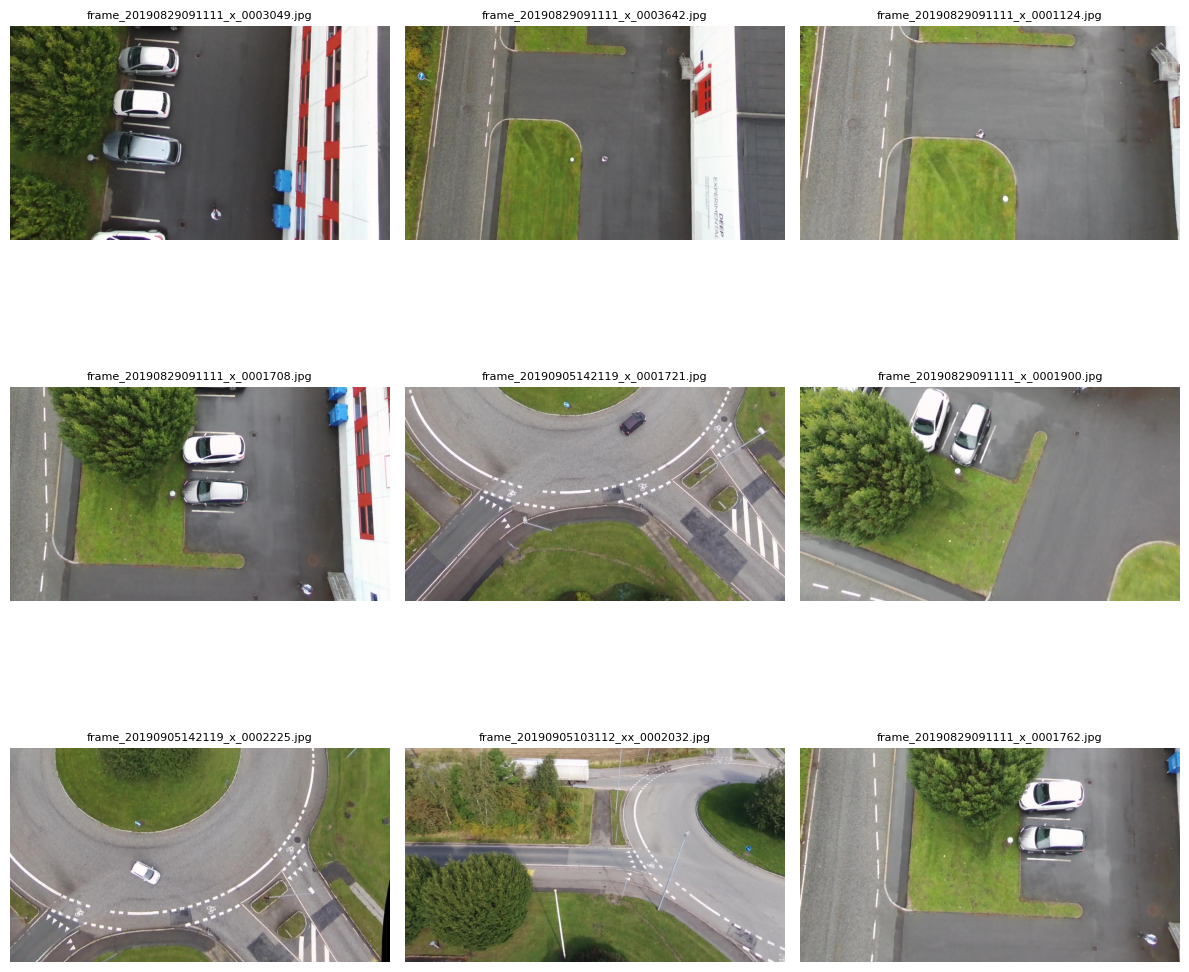

In [86]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import json

# Seçilen görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# YOLOS tahminlerini yükle (COCO format)
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

# Image ID'leri yerine isimleri bulabilmek için annotations_coco.json'u yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

image_id_to_name = {img["id"]: img["file_name"] for img in coco_gt["images"]}

# Tahmin yapılan image isimlerini bul
detected_image_names = set(image_id_to_name[pred["image_id"]] for pred in yolos_preds)

# Hiç tespit yapılmayan görselleri bul
no_detections = list(selected_images - detected_image_names)

print(f"Hiç tespit yapılamayan görsel sayısı: {len(no_detections)}")

# İlk 9 tanesini grid olarak görselleştir
n = min(9, len(no_detections))
plt.figure(figsize=(12, 12))
for i, filename in enumerate(no_detections[:n]):
    img_path = os.path.join("/content/images", filename)
    image = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{filename}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


analyze

Human: TP=69, FP=121, FN=5089, Precision=0.36, Recall=0.01
Car: TP=5692, FP=19344, FN=96927, Precision=0.23, Recall=0.06
Truck: TP=425, FP=1318, FN=9120, Precision=0.24, Recall=0.04
Van: TP=0, FP=0, FN=9995, Precision=0.00, Recall=0.00
Motorbike: TP=2, FP=9, FN=317, Precision=0.18, Recall=0.01
Bicycle: TP=3, FP=3, FN=1125, Precision=0.50, Recall=0.00
Bus: TP=29, FP=108, FN=700, Precision=0.21, Recall=0.04
Trailer: TP=0, FP=0, FN=2538, Precision=0.00, Recall=0.00


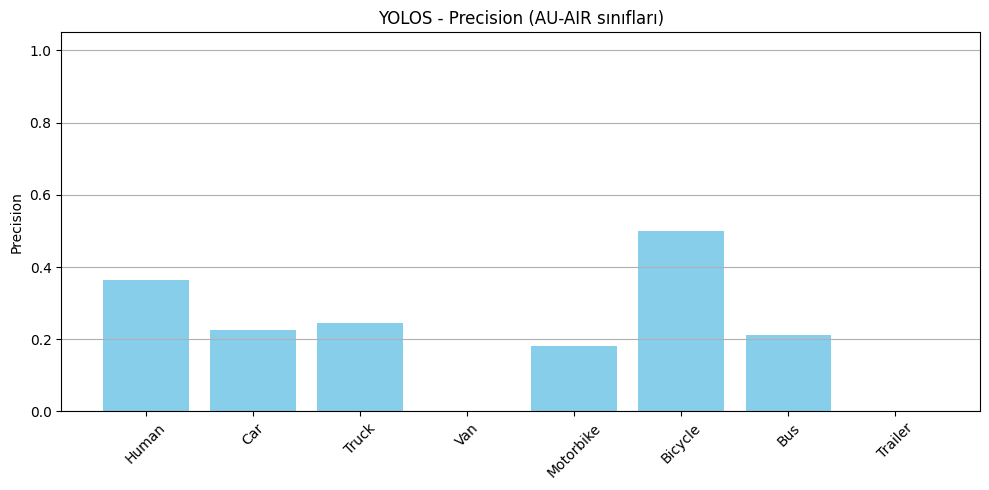

In [84]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# AU-AIR sınıfları (COCO kategori ID'leri ile eşlenmiş)
auair_classes = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# 1. Ground-truth (COCO format) yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

gt_by_image = defaultdict(list)
for ann in coco_gt["annotations"]:
    image_id = ann["image_id"]
    category_name = auair_classes[ann["category_id"]]
    gt_by_image[image_id].append(category_name)

# 2. YOLOS tahminlerini (COCO format) yükle
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

preds_by_image = defaultdict(list)
for pred in yolos_preds:
    image_id = pred["image_id"]
    category_name = auair_classes[pred["category_id"]]
    preds_by_image[image_id].append(category_name)

# 3. TP, FP, FN hesapla
results = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in auair_classes.values()}

all_image_ids = set(gt_by_image.keys()).union(set(preds_by_image.keys()))

for image_id in all_image_ids:
    gt_labels = gt_by_image.get(image_id, [])
    pred_labels = preds_by_image.get(image_id, [])

    for cls in auair_classes.values():
        tp = min(pred_labels.count(cls), gt_labels.count(cls))
        fp = max(pred_labels.count(cls) - gt_labels.count(cls), 0)
        fn = max(gt_labels.count(cls) - pred_labels.count(cls), 0)
        results[cls]["TP"] += tp
        results[cls]["FP"] += fp
        results[cls]["FN"] += fn

# 4. Precision & Recall hesapla
for cls in auair_classes.values():
    TP = results[cls]["TP"]
    FP = results[cls]["FP"]
    FN = results[cls]["FN"]
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    results[cls]["Precision"] = round(precision, 3)
    results[cls]["Recall"] = round(recall, 3)

# 5. Yazdır
for cls in auair_classes.values():
    r = results[cls]
    print(f"{cls}: TP={r['TP']}, FP={r['FP']}, FN={r['FN']}, "
          f"Precision={r['Precision']:.2f}, Recall={r['Recall']:.2f}")

# 6. Grafik (Precision)
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [r["Precision"] for r in results.values()], color="skyblue")
plt.title("YOLOS - Precision (AU-AIR sınıfları)")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


mAP

In [77]:
!pip install pycocotools


In [88]:
import json

# Seçilen görüntü isimlerini oku
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# COCO formatındaki tam annotation dosyasını yükle
with open("/content/annotations_coco.json") as f:
    full_coco = json.load(f)

# image_name → image_id eşlemesi
selected_images_data = [img for img in full_coco["images"] if img["file_name"] in selected_images]
selected_image_ids = set(img["id"] for img in selected_images_data)

# Sadece bu image_id'lere ait annotation'ları al
selected_annotations = [ann for ann in full_coco["annotations"] if ann["image_id"] in selected_image_ids]

# Yeni COCO objesi oluştur
filtered_coco = {
    "info": full_coco["info"],
    "licenses": full_coco["licenses"],
    "categories": full_coco["categories"],
    "images": selected_images_data,
    "annotations": selected_annotations
}

# Yeni dosyayı kaydet
with open("/content/annotations_coco_selected.json", "w") as f:
    json.dump(filtered_coco, f, indent=2)

print("Yeni filtered annotation dosyası oluşturuldu.")


Yeni filtered annotation dosyası oluşturuldu.


In [89]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected.json')  # your ground truth
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco.json')  # your YOLOS predictions

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.15s).
Accumulating evaluation results...
DONE (t=0.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [90]:
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
from transformers import DetrImageProcessor, YolosForObjectDetection
import wandb

# ✅ 1. WandB başlat
wandb.init(project="object_detection", name="yolos-inference-on-auair")

# ✅ 2. AU-AIR sınıf isimleri ve COCO → AU-AIR sınıf eşleme
coco_to_auair = {
    "person": 1, "car": 2, "truck": 3, "van": 4,
    "motorcycle": 5, "bicycle": 6, "bus": 7, "trailer": 8
}

# ✅ 3. Görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# ✅ 4. Model ve işlemciyi yükle
processor = DetrImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
model.eval().to("cuda")

# ✅ 5. Görsel klasörü ve JSON çıktısı
image_folder = "/content/images"
output_json = "/content/yolos_predictions_coco_lowerthreshold.json"
coco_predictions = []

# Ground truth annotations (image_name -> image_id eşlemesi)
with open('/content/annotations_coco.json', 'r') as f:
    gt_coco = json.load(f)
image_name_to_id = {img["file_name"]: img["id"] for img in gt_coco["images"]}

# ✅ 6. WandB tablosu oluştur
wandb_table = wandb.Table(columns=["Image", "Label", "Score", "BBox"])

# ✅ 7. Görselleri sırayla işle
for filename in tqdm(os.listdir(image_folder)):
    if not filename.endswith(".jpg") or filename not in selected_images:
        continue

    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        inputs_clean = {k: v for k, v in inputs.items() if k != "pixel_mask"}
        outputs = model(**inputs_clean)

    target_sizes = torch.tensor([image.size[::-1]]).to("cuda")
    results_per_image = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.5)[0]

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results_per_image["scores"],
                                 results_per_image["labels"],
                                 results_per_image["boxes"]):
        coco_label = model.config.id2label[label.item()]
        if coco_label not in coco_to_auair:
            continue

        category_id = coco_to_auair[coco_label]
        score_val = round(score.item(), 3)
        xmin, ymin, xmax, ymax = [round(b, 2) for b in box.tolist()]
        width, height = xmax - xmin, ymax - ymin

        # COCO formatına uygun kayıt
        coco_predictions.append({
            "image_id": image_name_to_id[filename],
            "category_id": category_id,
            "bbox": [xmin, ymin, width, height],
            "score": score_val
        })

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin - 10), f"{coco_label} ({score_val})", fill="red")

        wandb_table.add_data(filename, coco_label, score_val, [xmin, ymin, xmax, ymax])

    wandb.log({f"prediction/{filename}": wandb.Image(image)})

# ✅ 8. JSON çıktısını kaydet (COCO format)
with open(output_json, "w") as f:
    json.dump(coco_predictions, f, indent=2)

print(f"COCO formatında tahminler kaydedildi: {output_json}")

# ✅ 9. WandB tabloyu gönder ve oturumu kapat
wandb.log({"detection_table": wandb_table})
wandb.finish()


100%|██████████| 32823/32823 [11:45<00:00, 46.55it/s]


COCO formatında tahminler kaydedildi: /content/yolos_predictions_coco_lowerthreshold.json


Human: TP=106, FP=408, FN=5052, Precision=0.21, Recall=0.02
Car: TP=5970, FP=38661, FN=96649, Precision=0.13, Recall=0.06
Truck: TP=551, FP=3538, FN=8994, Precision=0.14, Recall=0.06
Van: TP=0, FP=0, FN=9995, Precision=0.00, Recall=0.00
Motorbike: TP=2, FP=27, FN=317, Precision=0.07, Recall=0.01
Bicycle: TP=5, FP=8, FN=1123, Precision=0.39, Recall=0.00
Bus: TP=30, FP=190, FN=699, Precision=0.14, Recall=0.04
Trailer: TP=0, FP=0, FN=2538, Precision=0.00, Recall=0.00


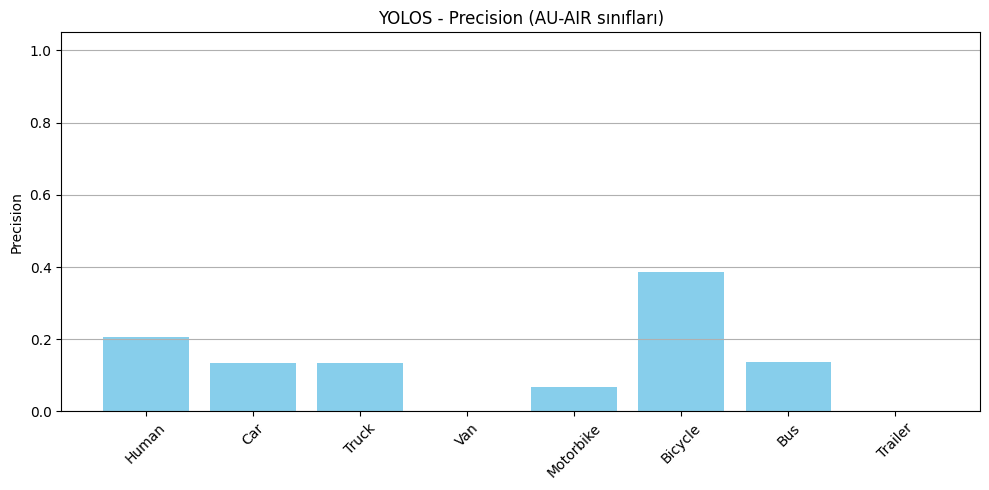

In [94]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# AU-AIR sınıfları (COCO kategori ID'leri ile eşlenmiş)
auair_classes = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# 1. Ground-truth (COCO format) yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

gt_by_image = defaultdict(list)
for ann in coco_gt["annotations"]:
    image_id = ann["image_id"]
    category_name = auair_classes[ann["category_id"]]
    gt_by_image[image_id].append(category_name)

# 2. YOLOS tahminlerini (COCO format) yükle
with open("/content/yolos_predictions_coco_lowerthreshold.json") as f:
    yolos_preds = json.load(f)

preds_by_image = defaultdict(list)
for pred in yolos_preds:
    image_id = pred["image_id"]
    category_name = auair_classes[pred["category_id"]]
    preds_by_image[image_id].append(category_name)

# 3. TP, FP, FN hesapla
results = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in auair_classes.values()}

all_image_ids = set(gt_by_image.keys()).union(set(preds_by_image.keys()))

for image_id in all_image_ids:
    gt_labels = gt_by_image.get(image_id, [])
    pred_labels = preds_by_image.get(image_id, [])

    for cls in auair_classes.values():
        tp = min(pred_labels.count(cls), gt_labels.count(cls))
        fp = max(pred_labels.count(cls) - gt_labels.count(cls), 0)
        fn = max(gt_labels.count(cls) - pred_labels.count(cls), 0)
        results[cls]["TP"] += tp
        results[cls]["FP"] += fp
        results[cls]["FN"] += fn

# 4. Precision & Recall hesapla
for cls in auair_classes.values():
    TP = results[cls]["TP"]
    FP = results[cls]["FP"]
    FN = results[cls]["FN"]
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    results[cls]["Precision"] = round(precision, 3)
    results[cls]["Recall"] = round(recall, 3)

# 5. Yazdır
for cls in auair_classes.values():
    r = results[cls]
    print(f"{cls}: TP={r['TP']}, FP={r['FP']}, FN={r['FN']}, "
          f"Precision={r['Precision']:.2f}, Recall={r['Recall']:.2f}")

# 6. Grafik (Precision)
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [r["Precision"] for r in results.values()], color="skyblue")
plt.title("YOLOS - Precision (AU-AIR sınıfları)")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [91]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected.json')  # your ground truth
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco_lowerthreshold.json')  # your YOLOS predictions

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [95]:
print(model.config.id2label)


{0: 'N/A', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'N/A', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'N/A', 27: 'backpack', 28: 'umbrella', 29: 'N/A', 30: 'N/A', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'N/A', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'N/A', 67: 'dining table', 68: 'N/A', 69: 'N/A', 70: 'toilet

In [98]:
import json

# Kullanılabilir AU-AIR → COCO sınıf eşleşmeleri
valid_class_ids = {1, 2, 3, 5, 6, 7}  # Human, Car, Truck, Motorbike, Bicycle, Bus

# Tam COCO annotation dosyasını yükle
with open("/content/annotations_coco_selected.json") as f:
    full_coco = json.load(f)

# Geçerli sınıf ID’lerine ait annotation’ları filtrele
filtered_annotations = [ann for ann in full_coco["annotations"] if ann["category_id"] in valid_class_ids]

# Bu annotation’ların ait olduğu image_id’leri topla
used_image_ids = {ann["image_id"] for ann in filtered_annotations}

# Bu image_id’lere ait görselleri al
filtered_images = [img for img in full_coco["images"] if img["id"] in used_image_ids]

# Yeni COCO dosyasını oluştur
filtered_coco = {
    "info": full_coco["info"],
    "licenses": full_coco["licenses"],
    "categories": [cat for cat in full_coco["categories"] if cat["id"] in valid_class_ids],
    "images": filtered_images,
    "annotations": filtered_annotations
}

# Kaydet
with open("/content/annotations_coco_selected_filtered.json", "w") as f:
    json.dump(filtered_coco, f, indent=2)

print("Sadece YOLOS'un desteklediği sınıflar için annotation dosyası oluşturuldu.")

import json

# Geçerli YOLOS sınıfları (COCO + AU-AIR eşleşenler)
valid_category_ids = {1, 2, 3, 5, 6, 7}

# Tahminleri yükle
with open("/content/yolos_predictions_coco.json") as f:
    all_preds = json.load(f)

# Filtrele
filtered_preds = [pred for pred in all_preds if pred["category_id"] in valid_category_ids]

# Yeni dosya olarak kaydet
with open("/content/yolos_predictions_coco_filtered.json", "w") as f:
    json.dump(filtered_preds, f, indent=2)

print("Van ve Trailer sınıfları çıkartıldı, yeni prediction dosyası hazır.")



Sadece YOLOS'un desteklediği sınıflar için annotation dosyası oluşturuldu.
Van ve Trailer sınıfları çıkartıldı, yeni prediction dosyası hazır.


annotations_coco_selected_filtered.json adlı daha dar bir ground-truth dosyası yaptın:

İçinde sadece 6 sınıfa ait annotation’lar var.

Bu işlem sonucunda bazı görseller hiç annotation içermediği için tamamen dışarı atıldı.

Ama yolos_predictions_coco_filtered.json dosyasındaki tahminlerde hala:

Bu dışarı atılan görsellerin image_id’lerine ait prediction’lar vardı.

In [102]:
import json

# Geçerli sınıf ID’leri
valid_category_ids = {1, 2, 3, 5, 6, 7}

# GT dosyasından geçerli image_id’leri çek
with open("/content/annotations_coco_selected_filtered.json") as f:
    gt_coco = json.load(f)

valid_image_ids = set(img["id"] for img in gt_coco["images"])

# Prediction dosyasını yükle
with open("/content/yolos_predictions_coco.json") as f:
    all_preds = json.load(f)

# Hem category_id hem de image_id'ye göre filtrele
filtered_preds = [
    pred for pred in all_preds
    if pred["category_id"] in valid_category_ids and pred["image_id"] in valid_image_ids
]

# Yeni dosya olarak kaydet
with open("/content/yolos_predictions_coco_filtered_strict.json", "w") as f:
    json.dump(filtered_preds, f, indent=2)

print(f"Geçerli {len(filtered_preds)} tahmin saklandı. Dosya hazır.")


Geçerli 26131 tahmin saklandı. Dosya hazır.


In [103]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected_filtered.json')
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco_filtered_strict.json')

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets